In [15]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

Tensorflow version 2.8.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configurations

**Testing**

In [19]:
from __future__ import division
import numpy as np
from scipy.signal import convolve2d
from skimage import io, color
from skimage.feature import local_binary_pattern

def lpq(img,winSize=3,freqestim=1,mode='nh'):
    rho=0.90
    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()
    return LPQdesc


def lbp_histogram(color_image, p=8, r = 1):
    img = color.rgb2gray(color_image)
    patterns = local_binary_pattern(img, p, r)
    hist, _ = np.histogram(patterns, bins=np.arange(2**8 + 1), density=True)
    return hist

In [17]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomFlip(mode='horizontal', seed=1996), 
    ],
    name="img_augmentation",
)

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
NUM_CLASSES = 2
IMG_SIZE = 256

In [ ]:
def create_model():
  inputs_image = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  # inputs_image = img_augmentation(inputs_image)
  resnet_model = ResNet50(include_top=False, input_tensor=inputs_image, weights="imagenet")
  resnet_model.trainable = True
  x = layers.GlobalAveragePooling2D(name="avg_pool")(resnet_model.output)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dense(512)(x)
  model_image = tf.keras.Model(inputs_image, outputs, name="model_image")

  input_lbp = layers.Input(shape=(256))
  lbp_model = Sequential(
      [
      layers.Dense(512, activation="relu"), 
      layers.BatchNormalization(),
      layers.Dense(256), 
      ]
  )
  lbp_model(input_lbp)

  combined = layers.concatenate([model_image.output, lbp_model.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = layers.Dense(1024, activation="relu")(combined)
  z = layers.Dense(512, activation="relu")(z)
  top_dropout_rate = 0.05
  z = layers.Dropout(top_dropout_rate, name="top_dropout")(z)
  z = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(z)

  # our model will accept the inputs of the two branches and
  # then output a single value
  model = tf.keras.Model(inputs=[model_image.input, lbp_model.input], outputs=z)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(
          optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy']
      )
  
  return model

In [ ]:
pip install mtcnn

In [25]:
from mtcnn import MTCNN
from PIL import Image
import cv2
detector = MTCNN()

In [28]:
def get_face_pil(path):
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
  res = detector.detect_faces(img)
  x,y, width, height = res[0]['box']
  left = x; top = y; right = x + width; bottom = y + height
  face = Image.open(path).crop([left, top, right, bottom])
  return face

def get_lbp(face_pil):
  rgb_array = np.asarray(face_pil)
  return lbp_histogram(rgb_array, 8, 1)

In [29]:
face = get_face_pil('/content/MicrosoftTeams-image (27).png')
lbp = get_lbp(face)

In [31]:
np.expand_dims(lbp, axis=0)

(1, 256)

In [ ]:
model = create_model()

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/thesis/resnet50LBP_81/fasd_acc09794_dropout005.h5'

In [ ]:
model.load_weights(checkpoint_filepath)

In [39]:
sample_path = '/content/drive/MyDrive/thesis/sample/010.jpeg'

In [40]:
def get_input(path):
  face = get_face_pil(path).resize((256,256))
  lbp = get_lbp(face)
  face_arr = np.expand_dims(np.asarray(face), axis=0)
  lbp_arr = np.expand_dims(lbp, axis=0)
  return face_arr, lbp_arr

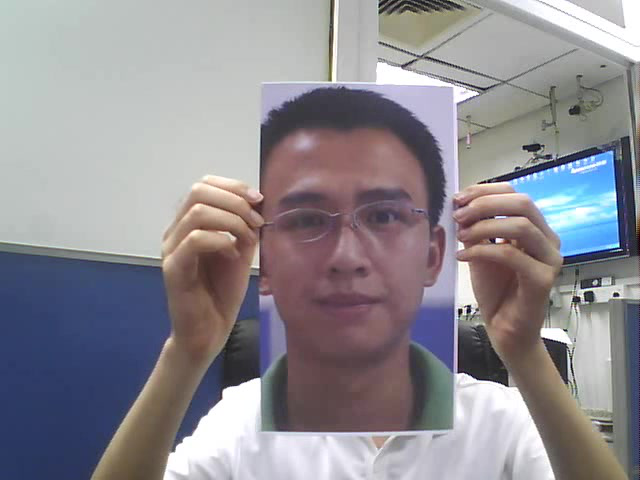

In [43]:
Image.open(sample_path)

In [41]:
face_arr, lbp_arr = get_input(sample_path)

In [42]:
model.predict([face_arr, lbp_arr])

array([[1.6431696e-09, 1.0000000e+00]], dtype=float32)